In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import kurtosis
from scipy import stats

from sktime.utils.plotting import plot_series

### Задание 1
Прочитать файл 'G2.csv' и 'test.csv'

In [2]:
G2 = pd.read_csv(r"C:\Users\user\Interviews\Тестовое задание CityAir\Задание\G2.csv")
test = pd.read_csv(r"C:\Users\user\Interviews\Тестовое задание CityAir\Задание\test.csv")

In [3]:
G2.head(5)

,date,SO2op1,SO2op2,T,SO2,NO2
0,2022-06-22 09:06:24,389.807,345.705,20.844,448.0,0.0
1,2022-06-22 09:06:54,390.261,345.983,20.875,448.0,0.0
2,2022-06-22 09:07:24,390.261,345.983,20.844,448.0,0.0
3,2022-06-22 09:07:54,389.708,345.844,20.875,448.0,0.0
4,2022-06-22 09:08:24,389.708,345.844,20.875,448.0,0.0


In [4]:
test.head(5)

,date,SO2op1,SO2op2,T,NO2
0,2022-09-12 08:00:00,348.10,344.89,9.845,43.446494
1,2022-09-12 08:05:00,348.20,344.58,9.845,45.494829
2,2022-09-12 08:10:00,348.06,344.53,9.910,45.498952
3,2022-09-12 08:15:00,348.06,344.61,9.970,42.848022
4,2022-09-12 08:20:00,348.30,344.83,10.030,42.880397


### Задание 2 
Предложить модель, которая осуществляет следующую зависимость: 

$$
S02 = f(SO2op1, SO2op2, T, NO2)
$$

#### Поработаем с данными

##### Типы данных

In [5]:
# Посмотрим на типы данных
G2.dtypes 
# Как видим data имеет type object, переведем в datetime
# Все остальные 

date       object
SO2op1    float64
SO2op2    float64
T         float64
SO2       float64
NO2       float64
dtype: object

In [6]:
# %%writefile convert_time.py # для сохранения и дальнейшего использования
def convert_timestamp(data,column, format_:str = '%Y-%m-%d %H:%M:%S', ) -> datetime:
    timestamp = data[column]
    timestamp = pd.to_datetime(timestamp, format = format_)
    return timestamp

In [7]:
G2['date'] = convert_timestamp(G2, 'date')

In [8]:
# можно использовать для этих данных тип int (для сохранения памяти)
assert (G2['SO2'] == G2['SO2'].astype('int')).sum()
assert (G2['NO2'] == G2['NO2'].astype('int')).sum() 
G2['NO2'] = G2['NO2'].astype('int')
G2['SO2'] = G2['SO2'].astype('int')

In [9]:
G2.dtypes
# все круто

date      datetime64[ns]
SO2op1           float64
SO2op2           float64
T                float64
SO2                int32
NO2                int32
dtype: object

###### Описательные статистики и работы с нормальностью

In [10]:
# Посмотрим описательные статистики
G2.describe()

,SO2op1,SO2op2,T,SO2,NO2
count,156.000000,156.000000,156.000000,156.000000,156.000000
mean,324.248212,345.540891,20.936311,89.025641,334.769231
std,57.052503,0.351442,0.136996,158.247742,438.963381
min,234.286000,344.685000,20.781500,0.000000,0.000000
25%,284.888000,345.245750,20.844000,0.000000,0.000000
50%,353.593000,345.592500,20.875000,0.000000,0.000000
75%,376.545750,345.815000,21.125000,224.000000,544.000000
max,390.261000,346.267000,21.187500,448.000000,1088.000000


In [11]:
# Посмотрим сколько уникальых значений принимает каждый признак
for feature in G2.columns:
    print(f' Признак {feature} принимает {G2[feature].unique().shape[0]} уникальных значений')

 Признак date принимает 156 уникальных значений
 Признак SO2op1 принимает 80 уникальных значений
 Признак SO2op2 принимает 81 уникальных значений
 Признак T принимает 7 уникальных значений
 Признак SO2 принимает 3 уникальных значений
 Признак NO2 принимает 3 уникальных значений


In [12]:
### Перекодируем наши переменную (NO2) в категориальные значения
d = {}
for i, value in enumerate(G2['NO2'].unique()):
    d[value] = i
G2['NO2'].replace(d, inplace=True)

In [13]:
# Посмотрим эксцесс
kurtosis = pd.DataFrame(kurtosis(G2.drop('date', axis=1), axis=0, bias=True), columns = ['Эксцесс'])\
.set_index(G2.drop('date', axis=1).columns)
kurtosis
# как мы видим, данные не имеют нормального распределения

,Эксцесс
SO2op1,-1.351088
SO2op2,-0.823911
T,-0.826403
SO2,0.588451
NO2,-0.985797


In [14]:
# Проведем теста Шапиро-Уилка: H0 - нормальное распределение, H1 - ненормальное
data = G2.drop('date', axis=1).copy()
α = 0.05
for column in data.columns:
    test_shapiro = stats.shapiro(data[column])
    if test_shapiro[0] > α:
        print(f'По статистике Шапиро-Уилка для признака "{column}" наблюдается ненормальное распределение ')
    else:
        print(f'По статистике Шапиро-Уилка для признака "{column}" наблюдается нормальное распределение ')

По статистике Шапиро-Уилка для признака "SO2op1" наблюдается ненормальное распределение 
По статистике Шапиро-Уилка для признака "SO2op2" наблюдается ненормальное распределение 
По статистике Шапиро-Уилка для признака "T" наблюдается ненормальное распределение 
По статистике Шапиро-Уилка для признака "SO2" наблюдается ненормальное распределение 
По статистике Шапиро-Уилка для признака "NO2" наблюдается ненормальное распределение 


Видеть для признаков нормальное распределение необязательно, но для таргета - желательно, поэтому создадим признак логарифм таргета


In [15]:
test_shapiro[0]

0.6998754739761353

In [16]:
G2['logSO2'] = np.log1p(G2['SO2'])
# Проверим распределена ли она нормально
print('p-value теста Шапиро-Уилка: ', stats.shapiro(G2['logSO2'])[0])
# К сожалению, опять ненормальное

p-value теста Шапиро-Уилка:  0.5722941160202026


Можно решить эту проблему с помощью преобразований Кокса-Бокса (в python плохая реализация, поэтому оставим это...)

###### Пропуски и некорректность в данных

In [17]:
# Посмотрим пропуски в данных
G2.isna().sum()
# Пропусков нет

date      0
SO2op1    0
SO2op2    0
T         0
SO2       0
NO2       0
logSO2    0
dtype: int64

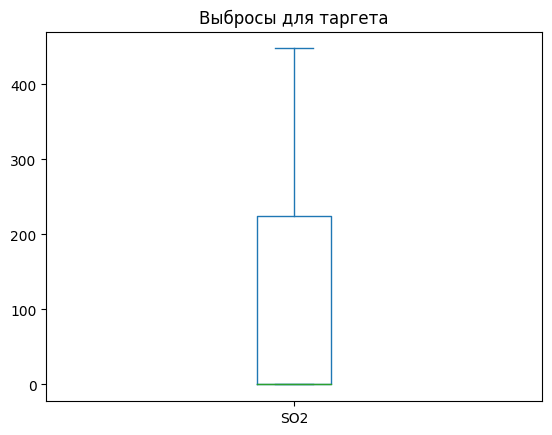

In [18]:
# Посмотрим на выбросы
# Для этого воспользуемся ящиком с усами 
# в реализация подразумевается статистическая проверка, поэтому мы не будем делать последнего
# Посмотрим на таргет
G2['SO2'].plot(kind='box', title='Выбросы для таргета')
plt.show()
# Все нормально

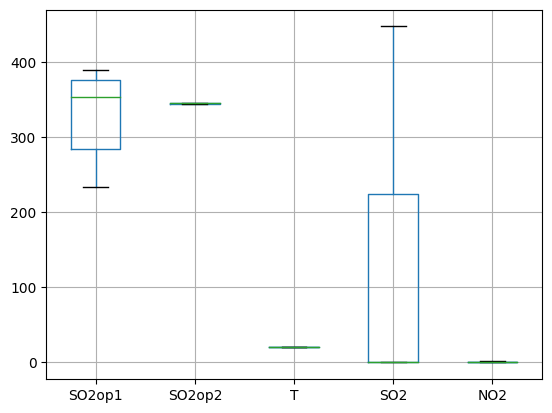

In [19]:
boxplot = data.boxplot(column=list(data.columns))

In [20]:
# Плохо видно, давайте посмотрим на другие графики

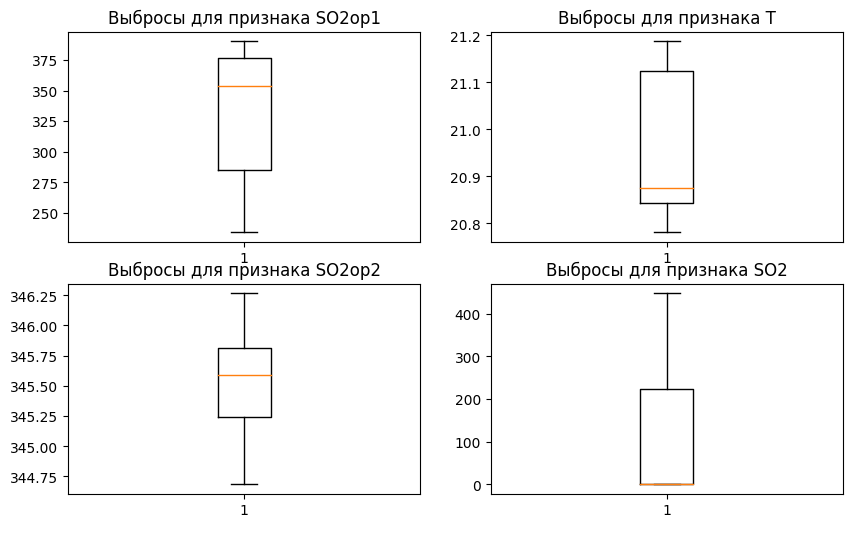

In [21]:
fig, ax = plt.subplots(2,2,  figsize=(10,6))
columns = data.columns
t = 0 
for j in range(2):
    for i in range(2):
        feature = columns[t]
        ax[i, j].boxplot(data[feature])
        ax[i, j].set_title(f'Выбросы для признака {feature}' )
        ax[i, j].set_xlabel(' ')
        t += 1 
# Выбросов не имеется

###### Корелляци

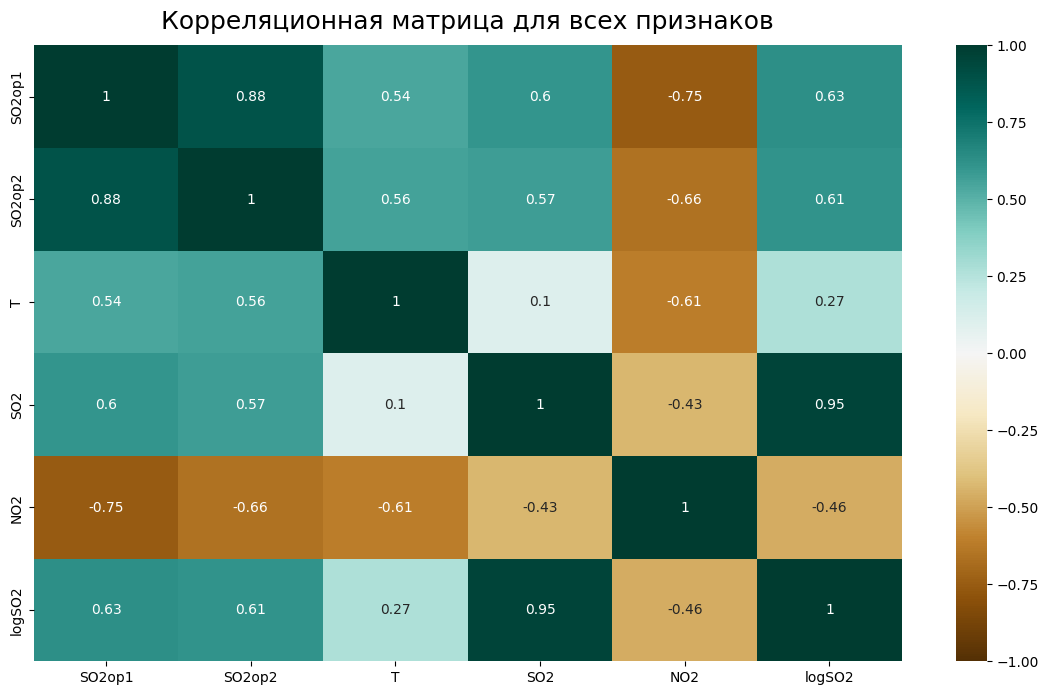

In [22]:
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(G2.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляционная матрица для всех признаков', fontdict={'fontsize':18}, pad=12);

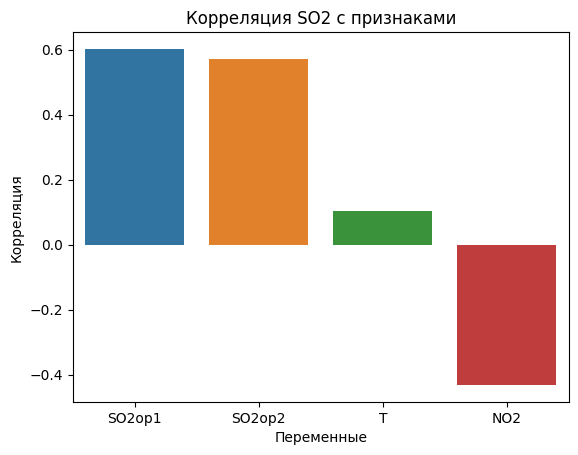

In [23]:
df = G2.corr()[['SO2']].reset_index().drop([3, 5])
sns.barplot(data = df, x = 'index', y = 'SO2')
plt.title('Корреляция SO2 с признаками');
plt.xlabel('Переменные')
plt.ylabel('Корреляция');

###### Графики (EDA)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='SO2'>)

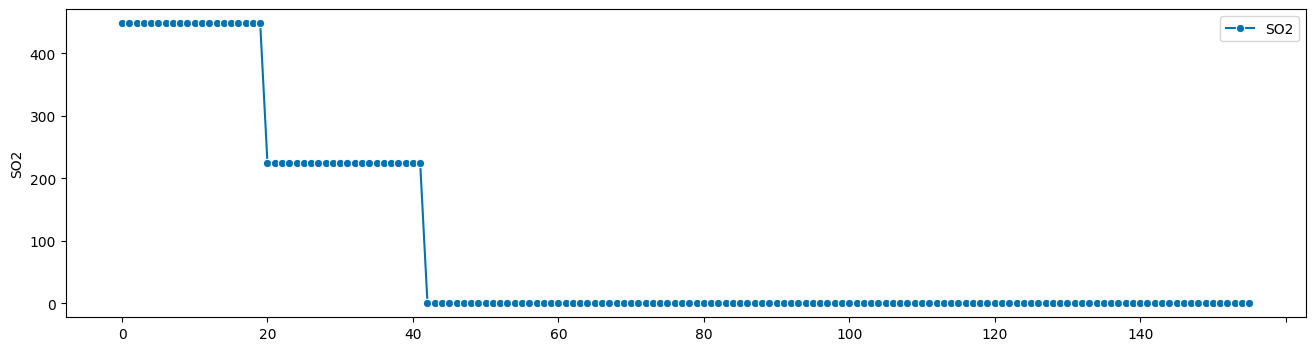

In [24]:
plot_series(G2['SO2'], labels = ['SO2'])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='SO2op1'>)

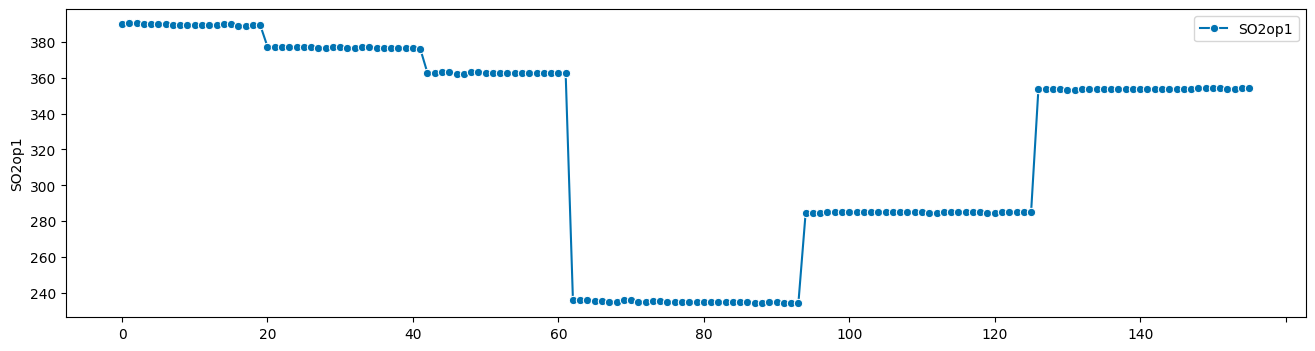

In [25]:
plot_series(G2['SO2op1'], labels = ['SO2op1'])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='SO2op2'>)

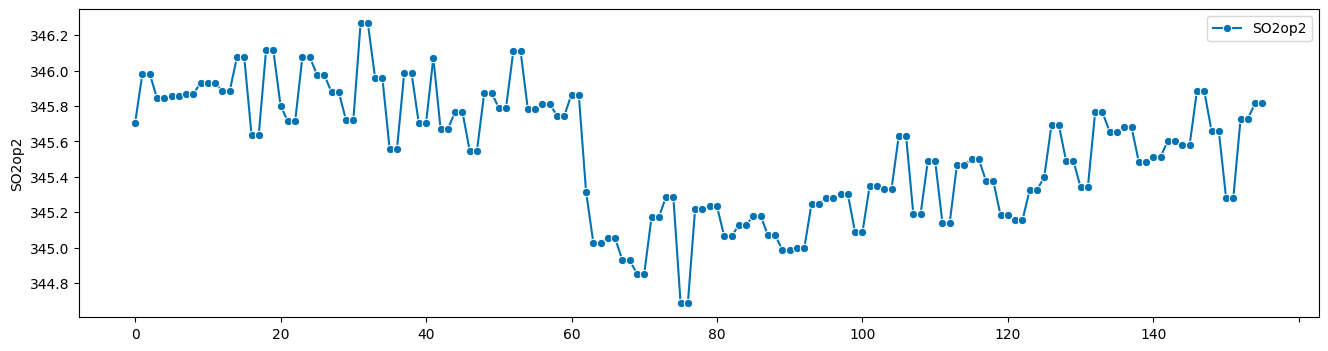

In [26]:
plot_series(G2['SO2op2'], labels=['SO2op2'])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='T'>)

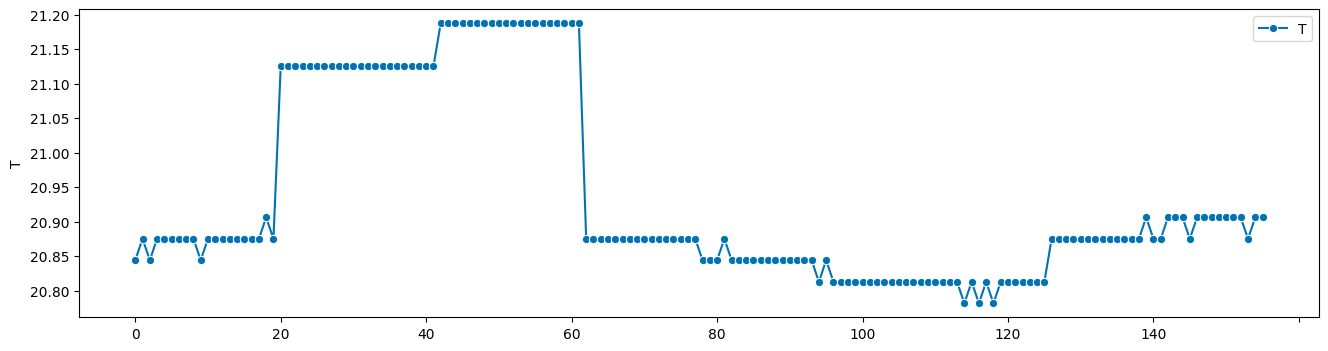

In [27]:
plot_series(G2['T'], labels=['T'])

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='NO2'>)

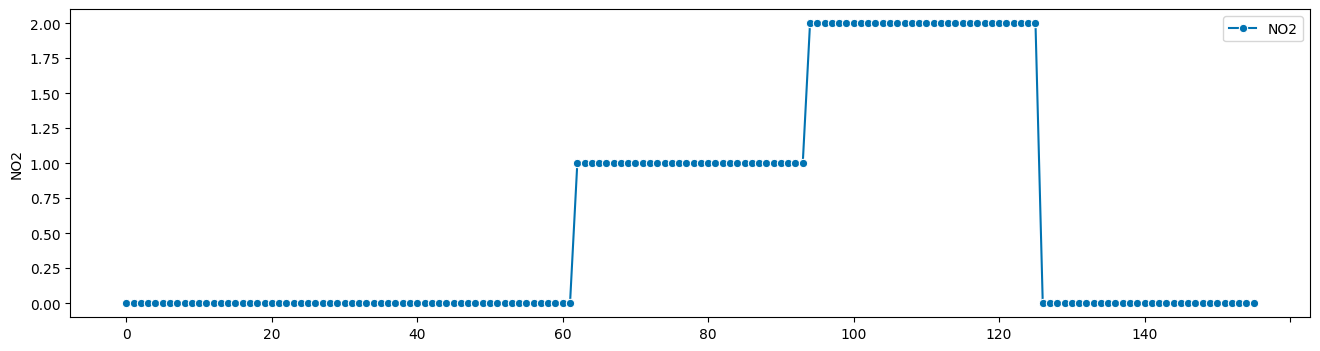

In [28]:
plot_series(G2['NO2'], labels=['NO2'])

###### Feature Engineering

In [29]:
# Попробуем создать новые переменные, сначала поработаем с временем
G2['hour'] = [j.hour for j in G2['date']]
G2['minute'] = [j.minute for j in G2['date']]
G2['second'] = [j.second for j in G2['date']]

In [30]:
# Попробуем взять лаги (1, 2, 3, 5, 7, 10)
# G2['SO2_1'] = G2['SO2'].shift(1)
# G2['SO2_2'] = G2['SO2'].shift(2)
# G2['SO2_3'] = G2['SO2'].shift(3)
# G2['SO2_5'] = G2['SO2'].shift(5)
# G2['SO2_7'] = G2['SO2'].shift(7)
# G2['SO2_10'] = G2['SO2'].shift(10)

Имеем следующие показатели:

* 156 наблюдений -> модель с большим количеством параметров не рассматриваем, так как может впасть в проблему размерности
* Перевели одну переменную в категориальную переменную (для более точной подачи)
* Пропусков не имеется
* Выбросов не имеется
* Самая сильная корреляция SO2 (далее таргета) имеется с SO2op1 (0.6)
* Самая слабая корреляция с T (0.1)
* Данные распределены не нормально -> создали логарифмированной переменной тоже не помогло, при построение модели это будет учтено
* Судя по графикам таргет имеет дискретное распределение, поэтому возможно лучше всего подойдут либо деревья, либо SVM (так как данные алгоритмы расбивают наше пространство с помощью прямых линий)
* Были созданы дополнительные переменные (лаги, переменнные времени, )
* Так нужно будет предсказывать по тесту (где мы имеем только признаковое пространство, не напрямую зависящее от таргета), то мы отказываемся от моделей класса Arima (ARMA, ARIMA, SARIMA, SARIMAX)
* Так как имеется категориальные переменные, то можно попробовать модели Catboost. В алгоритме встроен оптимальный прием работы именно с категориальными переменными.

# 3 задание

Рассмотрим метрику **RMSE** (так как она удобна с точки зрения интерпретации)


In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [32]:
G2.head(1)

,date,SO2op1,SO2op2,T,SO2,NO2,logSO2,hour,minute,second
0,2022-06-22 09:06:24,389.807,345.705,20.844,448,0,6.107023,9,6,24


In [106]:
# Разделим выборку на тест и трейн
X = G2.drop(['SO2', 'date', 'logSO2'], axis=1)
y = G2[['SO2']]
sc_X = StandardScaler()
X_scaler = sc_X.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_scaler, columns  = X.columns), y, train_size = 0.8, shuffle=True, random_state=123)

In [107]:
# Посмотрим на наш бейлайн, а именно на множественную регрессию
LR = LinearRegression()
model = LR.fit(X_train, y_train)
predict_train_LR = model.predict(X_train)
predict_test_LR = model.predict(X_test)
print(f'Ошибка на тренировочной выборке: {mean_squared_error(y_train, predict_train_LR) ** 0.5}')
print(f'Ошибка на тестовой выборке: {mean_squared_error(y_test, predict_test_LR) ** 0.5}')

Ошибка на тренировочной выборке: 21.14235413068123
Ошибка на тестовой выборке: 25.229854353810907


In [51]:
# Попробуем кросс-валидацию 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LR, X_scaler, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.array(-scores) ** 0.5) 
# Как мы видим дерево смогло идеально разбить наше признаковое пространство

32.52044294845662

In [50]:
SMV = SVR()
model = SMV.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
print(f'Ошибка на тренировочной выборке: {mean_squared_error(y_train, predict_train) ** 0.5}')
print(f'Ошибка на тестовой выборке: {mean_squared_error(y_test, predict_test) ** 0.5}')

Ошибка на тренировочной выборке: 176.7394512170032
Ошибка на тестовой выборке: 130.57467818358128


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
# Попробуем немного подобрать параметры
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
C_range = np.logspace(-1, 1, 3)
gamma_range = np.logspace(-1, 1, 3)
param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
scoring = ['MSE']
grid_search = GridSearchCV(estimator=SVR(), 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)
# Print grid search summary
grid_result

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([ 0.1,  1. , 10. ]),
                         'gamma': [0.1, 1.0, 10.0, 'scale', 'auto'],
                         'kernel': ['rbf', 'poly']},
             scoring='neg_mean_squared_error')

In [37]:
# Посмотрим на лучшую ошибку
print(f'Средняя ошибка на данных (кросс-валидационная) {-grid_result.best_score_:.4f}')
# Посмотрим на лучшие параметры модели, которая были подобраны с помощью GridSearch
print(f'Лучшие параметры модели {grid_result.best_params_}')

Средняя ошибка на данных (кросс-валидационная) 0.3070
Лучшие параметры модели {'C': 0.1, 'gamma': 10.0, 'kernel': 'poly'}


In [ ]:
SMV = SVR(C = 0.1, gamma= 10, kernel='poly')
model = SMV.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
print(f'Ошибка на тренировочной выборке: {mean_squared_error(y_train, predict_train) ** 0.5}')
print(f'Ошибка на тестовой выборке: {mean_squared_error(y_test, predict_test) ** 0.5}')
# 127 -> 36
# кросс-валидация зашита в методе GridSeach, а результаты были приведены выше. 

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [136]:
# Давайте посмотрим как эту задачу решает дерево
DT = DecisionTreeRegressor()
model = DT.fit(X_train, y_train)
predict_train_DT = model.predict(X_train)
predict_test_DT = model.predict(X_test)
print(f'Ошибка на тренировочной выборке: {mean_squared_error(y_train, predict_train_DT) ** 0.5}')
print(f'Ошибка на тестовой выборке: {mean_squared_error(y_test, predict_test_DT) ** 0.5}')
# Как мы видим дерево смогло идеально разбить нашу карту признаков, поэтому ошибка 0
# Также оно могло переробучиться, дабы проверить, что это не так, проведем кросс-валидацию

Ошибка на тренировочной выборке: 0.0
Ошибка на тестовой выборке: 0.0


In [39]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(DT, X_scaler, y, cv=10, scoring='neg_mean_squared_error')
np.mean(-scores)
# Как мы видим дерево смогло идеально разбить наше признаковое пространство

0.0

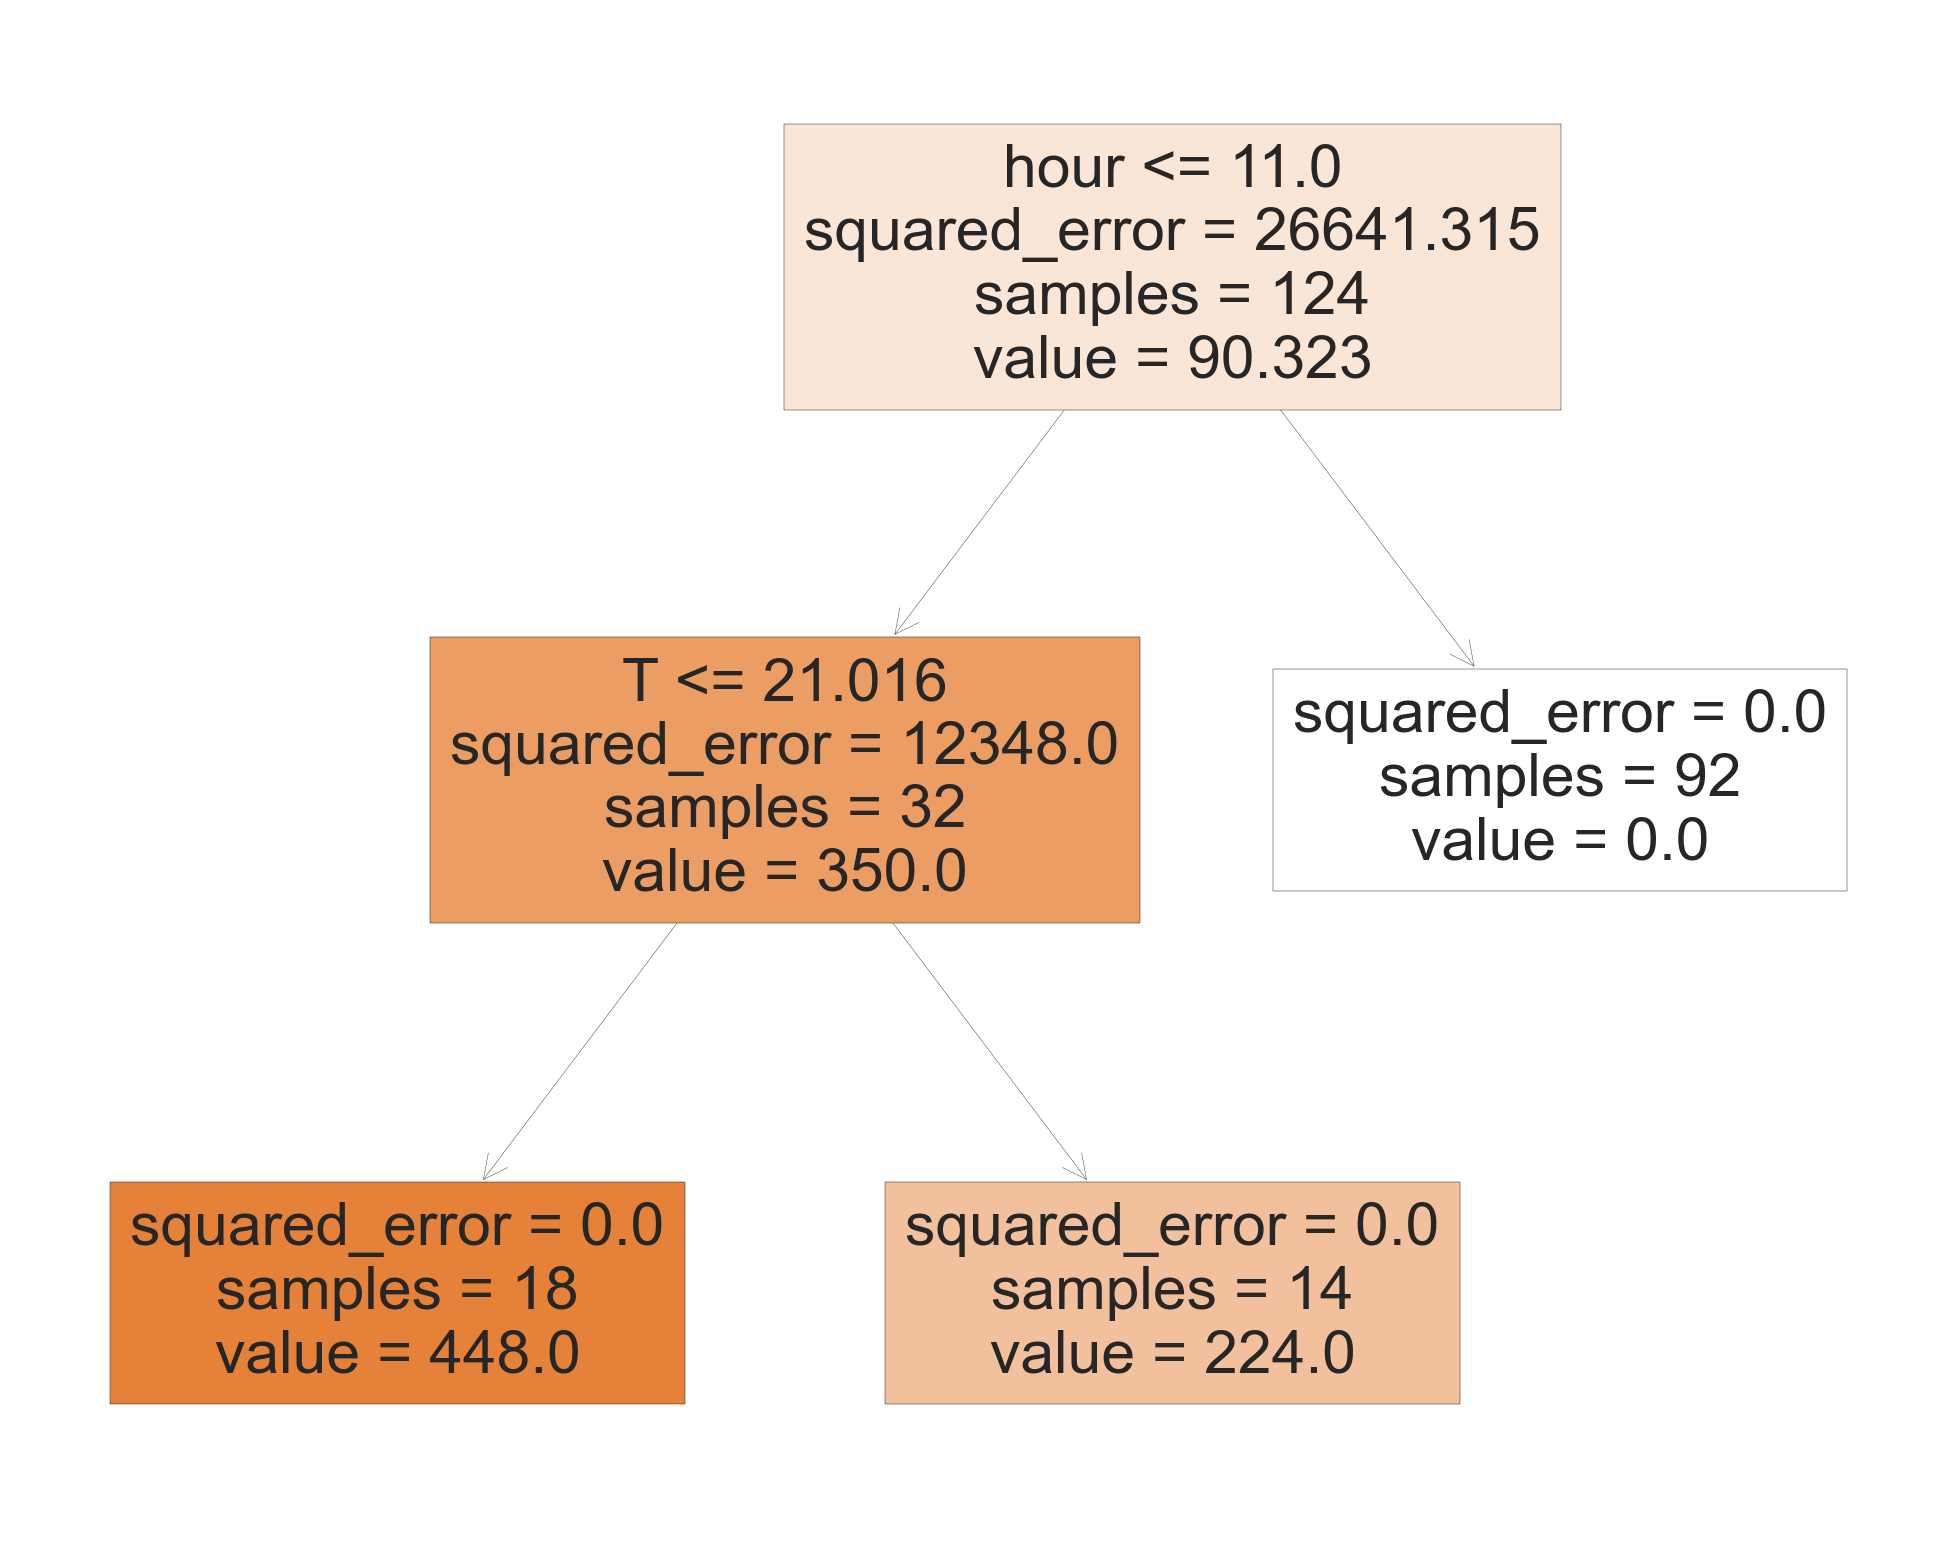

In [133]:
# Давайте посмотрим на то, как же оно разбивает наши признаки
from sklearn import tree
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle=True, random_state=123)
DT = DecisionTreeRegressor()
model = DT.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DT, 
                   feature_names=X.columns,  
                   class_names=y.columns,
                   filled=True)
# Как мы видим все зависит от определенного времени

# 4 задание

In [ ]:
# Сравнение

# 5 задание

In [ ]:
# Графики для ошибок по модели линейной регресии

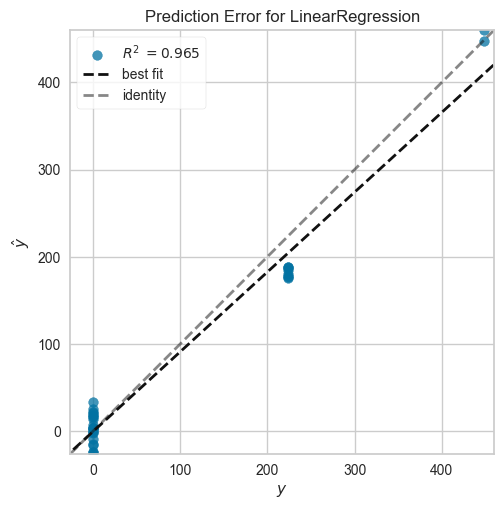

In [109]:
from yellowbrick.regressor import prediction_error
visualizer = prediction_error(LinearRegression(), X_train, y_train['SO2'], X_test, y_test['SO2'])

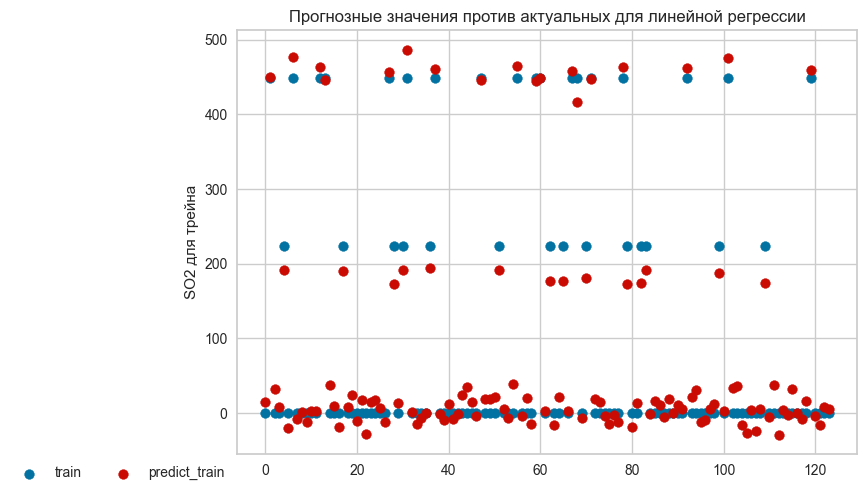

In [126]:
train_plot = plt.scatter(x = np.arange(0, y_train.shape[0]), y = y_train, color = 'b')
pred_plot  = plt.scatter(x = np.arange(0, y_train.shape[0]), y = predict_train_LR, color = 'r')
plt.legend((train_plot, pred_plot),
           ('train', 'predict_train'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           bbox_to_anchor=(0, 0),
           fontsize=10);
plt.ylabel('SO2 для трейна')
plt.title('Прогнозные значения против актуальных для линейной регрессии');

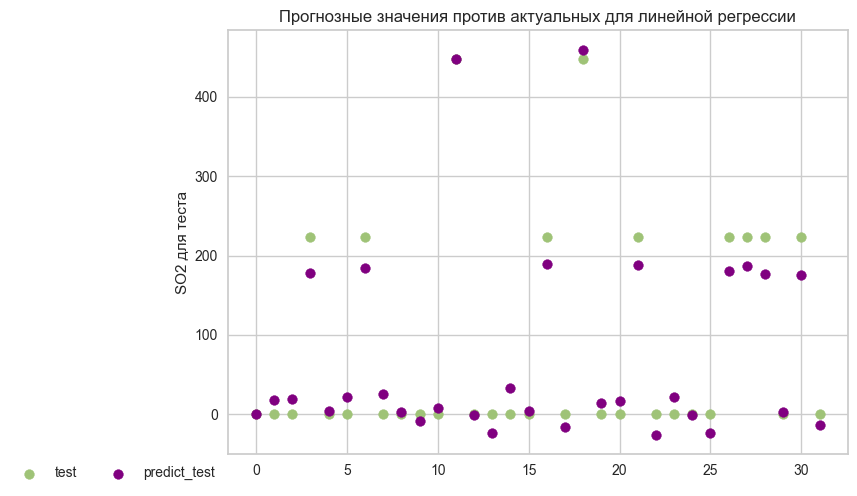

In [132]:
train_plot = plt.scatter(x = np.arange(0, y_test.shape[0]), y = y_test, color = 'g')
pred_plot  = plt.scatter(x = np.arange(0, y_test.shape[0]), y = predict_test_LR, color = 'purple')
plt.legend((train_plot, pred_plot),
           ('test', 'predict_test'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           bbox_to_anchor=(0, 0),
           fontsize=10);
plt.ylabel('SO2 для теста')
plt.title('Прогнозные значения против актуальных для линейной регрессии');

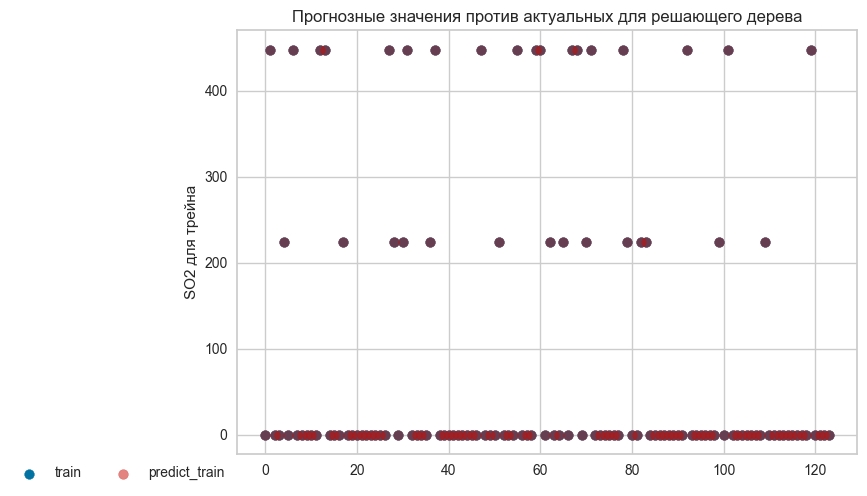

In [143]:
train_plot = plt.scatter(x = np.arange(0, y_train.shape[0]), y = y_train, color = 'b')
pred_plot  = plt.scatter(x = np.arange(0, y_train.shape[0]), y = predict_train_DT, color = 'r', alpha = 0.5)
plt.legend((train_plot, pred_plot),
           ('train', 'predict_train'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           bbox_to_anchor=(0, 0),
           fontsize=10);
plt.ylabel('SO2 для трейна')
plt.title('Прогнозные значения против актуальных для решающего дерева');

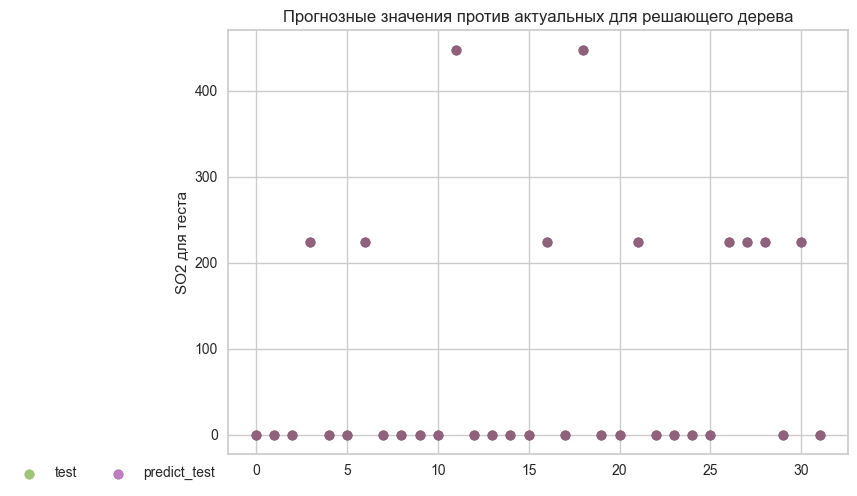

In [145]:
train_plot = plt.scatter(x = np.arange(0, y_test.shape[0]), y = y_test, color = 'g')
pred_plot  = plt.scatter(x = np.arange(0, y_test.shape[0]), y = predict_test_DT, color = 'purple', alpha = 0.5)
plt.legend((train_plot, pred_plot),
           ('test', 'predict_test'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           bbox_to_anchor=(0, 0),
           fontsize=10);
plt.ylabel('SO2 для теста')
plt.title('Прогнозные значения против актуальных для решающего дерева');

# 6 Задание